# Regressão Linear

Dada uma função *target* desconhecida $f:\mathbb{R}^{d} \rightarrow \mathbb{R}$ e uma hipótese $h_{\mathbf{w}}:\mathbb{R}^{d} \rightarrow \mathbb{R}$ o erro de $h_{\mathbf{w}}$ é definido por:

\begin{equation}
E_{out}(h_{\mathbf{w}}) = \mathbb{E}_{\mathbf{x}\sim p_{data}}L(h(\mathbf{x}; \mathbf{w}), \; f(\mathbf{x}))
\end{equation}

em que $p_{data}$ é a distribuição geradora dos dados, $L$  é alguma função de perda (por exemplo, o quadrado da diferença) e $h(\mathbf{x}; \mathbf{w}) = h_{\mathbf{w}}(\mathbf{x})$. Se tivéssemos acesso a $p_{data}$ poderíamos calcular a função acima para qualquer $h_{\mathbf{w}}$ e escolher aquele com erro mínimo.

Como não temos acesso a $p_{data}$, define-se

\begin{equation}
E_{in}(h_{\mathbf{w}}) = J(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^{N} L(h(\mathbf{x}_{i}; \mathbf{w}), \; y_{i})
\end{equation}

em que $N$ é o tamanho do dataset de treinamento e $y_{i} = f(\mathbf{x}_{i})$.

Queremos encontrar a função $h_{\mathbf{w}}$ mais próxima de $f$. Isto corresponde a determinar o ponto mínimo da função $J(\mathbf{w})$.

## Funções auxiliares

Importamos os pacotes e definimos as funções que usaremos ao longo do exercício.

In [28]:
from IPython.core.pylabtools import figsize, getfigs
from IPython.display import display
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston

def simple_step_plot(ylist, yname, title, figsize=(4, 4), labels=None):
    y0 = ylist[0]
    x = np.arange(1, len(y0) + 1, 1)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for y in ylist:
        ax.plot(x, y)
    plt.xlabel('step')
    plt.ylabel(yname)
    plt.title(title,
              fontsize=14,
              fontweight='bold')
    plt.grid(True)
    if labels is not None:
        plt.legend(labels,
           loc='upper right')
    plt.show()

## O dataset

Vamos usar o dataset *Boston Housing Prices*, organizado pelo grupo de *Machine Learning* da *University of California Irvine* e disponível para baixar diretamente através do pacote `sklearn`. Para facilitar a visualização dos resultados, vamos escolher apenas uma variável de entrada e prever o valor mediano da casa (em $1000s).

Text(0, 0.5, 'median value in $1000')

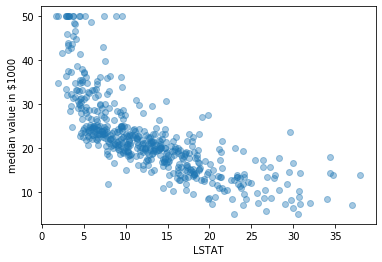

In [31]:
data = load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)

X = df.LSTAT.values.reshape((-1,1))
X = np.concatenate([X, np.ones((X.shape[0],1))], axis=1) # adiciona dimensão extra (bias)
y = data.target.reshape((-1,1))

plt.scatter(X[:,0], y, alpha=0.4)
plt.xlabel('LSTAT')
plt.ylabel('median value in $1000')

In [35]:
print(data['target'])

[24.  21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 15.  18.9 21.7 20.4
 18.2 19.9 23.1 17.5 20.2 18.2 13.6 19.6 15.2 14.5 15.6 13.9 16.6 14.8
 18.4 21.  12.7 14.5 13.2 13.1 13.5 18.9 20.  21.  24.7 30.8 34.9 26.6
 25.3 24.7 21.2 19.3 20.  16.6 14.4 19.4 19.7 20.5 25.  23.4 18.9 35.4
 24.7 31.6 23.3 19.6 18.7 16.  22.2 25.  33.  23.5 19.4 22.  17.4 20.9
 24.2 21.7 22.8 23.4 24.1 21.4 20.  20.8 21.2 20.3 28.  23.9 24.8 22.9
 23.9 26.6 22.5 22.2 23.6 28.7 22.6 22.  22.9 25.  20.6 28.4 21.4 38.7
 43.8 33.2 27.5 26.5 18.6 19.3 20.1 19.5 19.5 20.4 19.8 19.4 21.7 22.8
 18.8 18.7 18.5 18.3 21.2 19.2 20.4 19.3 22.  20.3 20.5 17.3 18.8 21.4
 15.7 16.2 18.  14.3 19.2 19.6 23.  18.4 15.6 18.1 17.4 17.1 13.3 17.8
 14.  14.4 13.4 15.6 11.8 13.8 15.6 14.6 17.8 15.4 21.5 19.6 15.3 19.4
 17.  15.6 13.1 41.3 24.3 23.3 27.  50.  50.  50.  22.7 25.  50.  23.8
 23.8 22.3 17.4 19.1 23.1 23.6 22.6 29.4 23.2 24.6 29.9 37.2 39.8 36.2
 37.9 32.5 26.4 29.6 50.  32.  29.8 34.9 37.  30.5 36.4 31.1 29.1 50.
 33.3 3


## Gradiente descendente

Dados $\mathbf{w}, \mathbf{u} \in \mathbb{R}^{d}$ e $J:\mathbb{R}^{d} \rightarrow \mathbb{R}$ tal que $||\mathbf{u}||_{2} = 1$ a taxa de variação de $J$ no ponto $\mathbf{w}$ em direção a $\mathbf{u}$ é chamada de **derivada direcional**, $D_{\mathbf{u}}J(\mathbf{w})$. Podemos minimizar $J$ alterando $\mathbf{w}$ na direção de $-\nabla_{\mathbf{w}}J(\mathbf{w})$.

- $\mathbf{w}(0) = \mathbf{w}$
- for $t = 0, 1, 2, \dots$ do
    * $\mathbf{w}(t+1) = \mathbf{w}(t) - \eta \nabla_{\mathbf{w}(t)}J(\mathbf{w}(t))$ 

O parâmetro $\eta \in \mathbb{R}_{\geq}$ é chamado de **taxa de aprendizado** (*learning rate*); ele pondera o tamanho de cada atualização.

### Computando a função de custo

Usando o erro quadrárico médio, a função de custo $J(\mathbf{w})$ para a tarefa de regressão linear pode ser escrita dessa forma:

\begin{equation}
J(\mathbf{w}) = \frac{1}{N}\sum_{i=1}^{N}(\hat{y}_{i} - y_{i})^{2}
\end{equation}

In [14]:
#TODO: implementar
def compute_cost(X, y, w):
    #TODO
    J = 999

    return J

### Computando os gradientes

A derivada parcial de $J(\mathbf{w})$ com relação a cada entrada $j$ de $\mathbf{w}$ é dada por

\begin{equation}
\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}_{j}} = \frac{2}{N}\sum_{i=1}^{N} (\hat{y}_i - y_i) \mathbf{x}_{ij}
\end{equation}

Lembre que o gradiente de $J(\mathbf{w})$ com relação a $\mathbf{w}$ é:

\begin{equation}
\nabla_{\mathbf{w}}J(\mathbf{w}) = \begin{bmatrix}\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}_{1}} \dots \frac{\partial J(\mathbf{w})}{\partial \mathbf{w}_{m}} \end{bmatrix}
\end{equation}

In [15]:
def compute_wgrad(X, y, w):
    """
    Calculates gradient of J(w) with respect to w.

    :param X: design matrix
    :type X: np.ndarray(shape=(N, d))
    :param y: regression targets
    :type y: np.ndarray(shape=(N, 1))
    :param w: weights
    :type w: np.array(shape=(d, 1))
    :return: gradient
    :rtype: np.array(shape=(d, 1))
    """
    N = X.shape[0]
    diff = np.dot(X,w) - y
    grad = 2/N * np.dot(np.transpose(X), diff)

    return grad

### Computando as atualizações dos pesos

A versão mais simples do algoritmo *gradient descent* faz uso de todas as observações do dataset de treinamento (esse algoritmo também é conhecido como *batch gradient descent* ou *vanilla gradient descent*).

**Batch gradient descent**

- $\mathbf{w}(0) = \mathbf{w}$
- for $t = 0, 1, 2, \dots$ do
    * Compute the gradient $\nabla_{\mathbf{w}(t)}J(\mathbf{w}(t))$ 
    * Apply update : $\mathbf{w}(t+1) = \mathbf{w}(t) - \eta \nabla_{\mathbf{w}(t)}J(\mathbf{w}(t))$

In [23]:
def gradient_descent(X, y, w, learning_rate, num_iters):
    
    weights_history = [w.flatten()]
    cost_history = [compute_cost(X, y, w)]

    w_current = w
    for t in range(0, num_iters-1):
        grad = compute_wgrad(X, y, w_current)
        w_current = w_current - learning_rate * grad
        weights_history.append(w_current.flatten())
        cost = compute_cost(X, y, w_current)
        cost_history.append(cost)
        if cost == 0:
            break

    return w, np.array(weights_history), cost_history 

In [32]:
X = np.zeros((10,2))
print(X)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


## Treinando o modelo

Experimente variar o *learning rate* e os pesos iniciais.

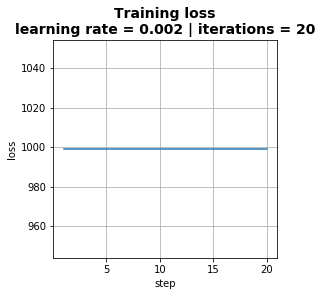

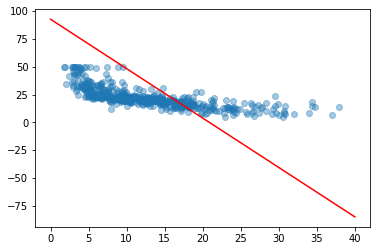

In [24]:
learning_rate = 0.002
initial_w = np.array([[100], [100]])
iterations = 20

w, weights_history, cost_history = gradient_descent(X, y, initial_w, learning_rate, iterations)
title = "Optimization landscape\nlearning rate = {} | iterations = {}".format(learning_rate, iterations)

simple_step_plot(
    [cost_history], 'loss',
    'Training loss\nlearning rate = {} | iterations = {}'.format(learning_rate, iterations))

plt.scatter(X[:,0], y, alpha=0.4)
x_reg = np.linspace(0, 40, 100)
y_reg = weights_history[-1,0]*x_reg + weights_history[-1,1]
plt.plot(x_reg, y_reg, c='r')